### Load libraries

In [1]:
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### BoW Model

In [2]:
class Dictionary(object):
    def __init__(self, name, img_filenames):
        self.name = name # name of your dictionary
        self.img_filenames = img_filenames # list of image filenames
        # self.num_words = num_words # the number of words
        self.training_data = [] # this is the training data required by the K-Means algorithm
        self.words = [] # list of words, which are the centroids of clusters
        
    def elbow(self, k_values):
        
        if len(k_values) <= 0:
            return
        
        sift = cv.xfeatures2d.SIFT_create()

        num_keypoints = [] # this is used to store the number of keypoints in each image
        training_data = []

        # load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    training_data.append(des)
                    
        Sum_of_squared_distances = []
        for k in k_values:
            km = KMeans(n_clusters=k)
            km = km.fit(training_data)
            Sum_of_squared_distances.append(km.inertia_)

        plt.plot(k_values, Sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum of squared distances')
        plt.title('Elbow Method For Optimal k')
        plt.show()
        
        
    def silhouette(self, k_values):
        sift = cv.xfeatures2d.SIFT_create()

        num_keypoints = [] # this is used to store the number of keypoints in each image
        training_data = []

        # load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    training_data.append(des)
            
                    
        for n_clusters in k_values:
            # Create a subplot with 1 row and 2 columns
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18, 7)

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 but in this example all
            # lie within [-0.1, 1]
            ax1.set_xlim([-0.1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(training_data) + (n_clusters + 1) * 10])

            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(training_data)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(training_data, cluster_labels)
            print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is :",
                silhouette_avg,
            )

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(training_data, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            
            np_training_data = np.array(training_data)

            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(
                np_training_data[:, 0], np_training_data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(
                centers[:, 0],
                centers[:, 1],
                marker="o",
                c="white",
                alpha=1,
                s=200,
                edgecolor="k",
            )

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

            plt.suptitle(
                "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
                % n_clusters,
                fontsize=14,
                fontweight="bold",
            )

        plt.show()

    def learn(self, num_words):
        sift = cv.xfeatures2d.SIFT_create()

        num_keypoints = [] # this is used to store the number of keypoints in each image

        # load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)

        # cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_

        # create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            # for each file, create a histogram
            histogram = np.zeros(num_words, np.float32)
            # if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)

        return training_word_histograms

    def create_word_histograms(self, img_filenames, num_words):
        sift = cv.xfeatures2d.SIFT_create()
        histograms = []

        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            histogram = np.zeros(num_words, np.float32) # word histogram for the input image

            if descriptors is not None:
                for des in descriptors:
                    # find the best matching word
                    min_distance = 1111111 # this can be any large number
                    matching_word_ID = -1 # initial matching_word_ID=-1 means no matching

                    for i in range(0, num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
                    histogram[matching_word_ID] += 1
                histogram /= len(descriptors) #normalise histogram to frequencies
            histograms.append(histogram)
        return histograms

### Loading Data 

In [3]:
import os

tools = ['hammer', 'pliers', 'screw_driver', 'wrench']
path = 'ToolImages/'

def get_data(dir_name):
    file_names = []
    tool_labels = []
    for i in range(0, len(tools)):
        sub_path = path + dir_name + '/' + tools[i] + '/'
        sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
        sub_tool_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
        file_names += sub_file_names
        tool_labels += sub_tool_labels
    return (file_names, tool_labels)

In [4]:
training_data = get_data('Train')
training_file_names = training_data[0]
training_tool_labels = training_data[1]

In [5]:
print(training_file_names)

['ToolImages/Train/hammer/000002.jpg', 'ToolImages/Train/hammer/000013.jpg', 'ToolImages/Train/hammer/000014.jpg', 'ToolImages/Train/hammer/000015.jpg', 'ToolImages/Train/hammer/000016.jpg', 'ToolImages/Train/hammer/000017.jpg', 'ToolImages/Train/hammer/000018.jpg', 'ToolImages/Train/hammer/000020.jpg', 'ToolImages/Train/hammer/000022.jpg', 'ToolImages/Train/hammer/000037.jpg', 'ToolImages/Train/hammer/000042.jpg', 'ToolImages/Train/hammer/000046.jpg', 'ToolImages/Train/hammer/000047.jpg', 'ToolImages/Train/hammer/000048.jpg', 'ToolImages/Train/hammer/000049.jpg', 'ToolImages/Train/hammer/000052.jpg', 'ToolImages/Train/hammer/000053.jpg', 'ToolImages/Train/hammer/000061.jpg', 'ToolImages/Train/hammer/000063.jpg', 'ToolImages/Train/hammer/000069.jpg', 'ToolImages/Train/hammer/000070.jpg', 'ToolImages/Train/hammer/000071.jpg', 'ToolImages/Train/hammer/000072.jpg', 'ToolImages/Train/hammer/000074.jpg', 'ToolImages/Train/hammer/000075.jpg', 'ToolImages/Train/hammer/000083.jpg', 'ToolImages

In [6]:
testing_data = get_data('Test')
test_file_names = testing_data[0]
test_tool_labels = testing_data[1]

In [7]:
print(test_file_names)

['ToolImages/Test/hammer/0000273.jpg', 'ToolImages/Test/hammer/000117.jpg', 'ToolImages/Test/hammer/000118.jpg', 'ToolImages/Test/hammer/000120.jpg', 'ToolImages/Test/hammer/000121.jpg', 'ToolImages/Test/hammer/000122.jpg', 'ToolImages/Test/hammer/000126.jpg', 'ToolImages/Test/hammer/000127.jpg', 'ToolImages/Test/hammer/000129.jpg', 'ToolImages/Test/hammer/000134.jpg', 'ToolImages/Test/hammer/000135.jpg', 'ToolImages/Test/hammer/000153.jpg', 'ToolImages/Test/hammer/000154.jpg', 'ToolImages/Test/hammer/000155.jpg', 'ToolImages/Test/hammer/000167.jpg', 'ToolImages/Test/hammer/000169.jpg', 'ToolImages/Test/hammer/000170.jpg', 'ToolImages/Test/hammer/000176.jpg', 'ToolImages/Test/hammer/000177.jpg', 'ToolImages/Test/hammer/000187.jpg', 'ToolImages/Test/hammer/000192.jpg', 'ToolImages/Test/hammer/000203.jpg', 'ToolImages/Test/hammer/000205.jpg', 'ToolImages/Test/hammer/000208.jpg', 'ToolImages/Test/hammer/000209.jpg', 'ToolImages/Test/hammer/000211.jpg', 'ToolImages/Test/hammer/000214.jpg',

In [8]:
dictionary_name = 'tool'
dictionary = Dictionary(dictionary_name, training_file_names)

### Clusters

In [9]:
k_2 = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]

In [10]:
k_3 = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]

### Elbow Method

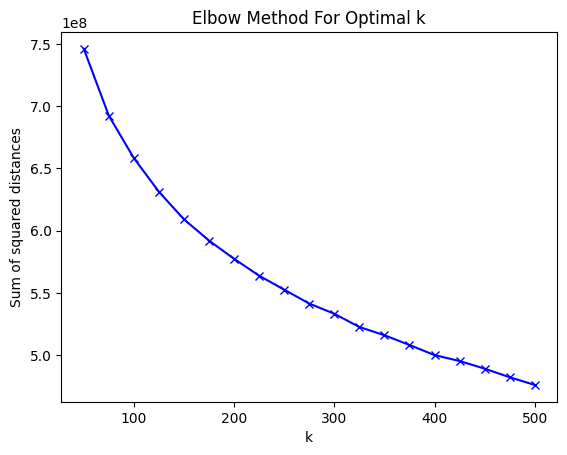

In [11]:
dictionary.elbow(k_2)

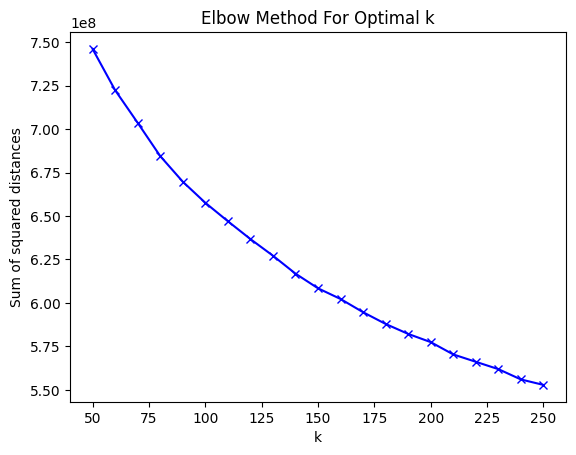

In [12]:
dictionary.elbow(k_3)

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Silhouette Analysis

For n_clusters = 50 The average silhouette_score is : 0.1122023
For n_clusters = 60 The average silhouette_score is : 0.10374667
For n_clusters = 70 The average silhouette_score is : 0.097595625
For n_clusters = 80 The average silhouette_score is : 0.09794261
For n_clusters = 90 The average silhouette_score is : 0.09787407
For n_clusters = 100 The average silhouette_score is : 0.094843164
For n_clusters = 110 The average silhouette_score is : 0.07458802
For n_clusters = 120 The average silhouette_score is : 0.072990835
For n_clusters = 130 The average silhouette_score is : 0.086040564
For n_clusters = 140 The average silhouette_score is : 0.0870144
For n_clusters = 150 The average silhouette_score is : 0.07199616
For n_clusters = 160 The average silhouette_score is : 0.07058725
For n_clusters = 170 The average silhouette_score is : 0.06440761
For n_clusters = 180 The average silhouette_score is : 0.066796996
For n_clusters = 190 The average silhouette_score is : 0.06630591
For n_cluste

C:\Users\souvik\AppData\Local\Temp\ipykernel_2844\211259830.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


For n_clusters = 250 The average silhouette_score is : 0.06234285


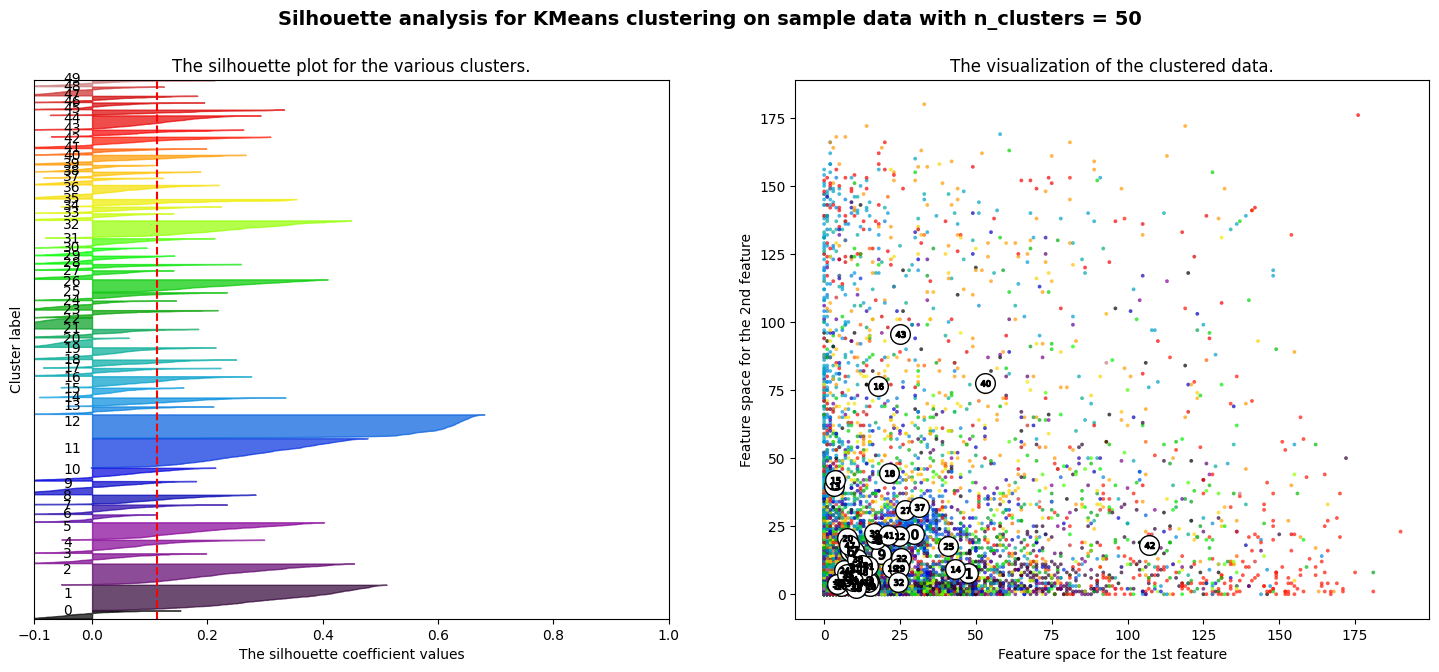

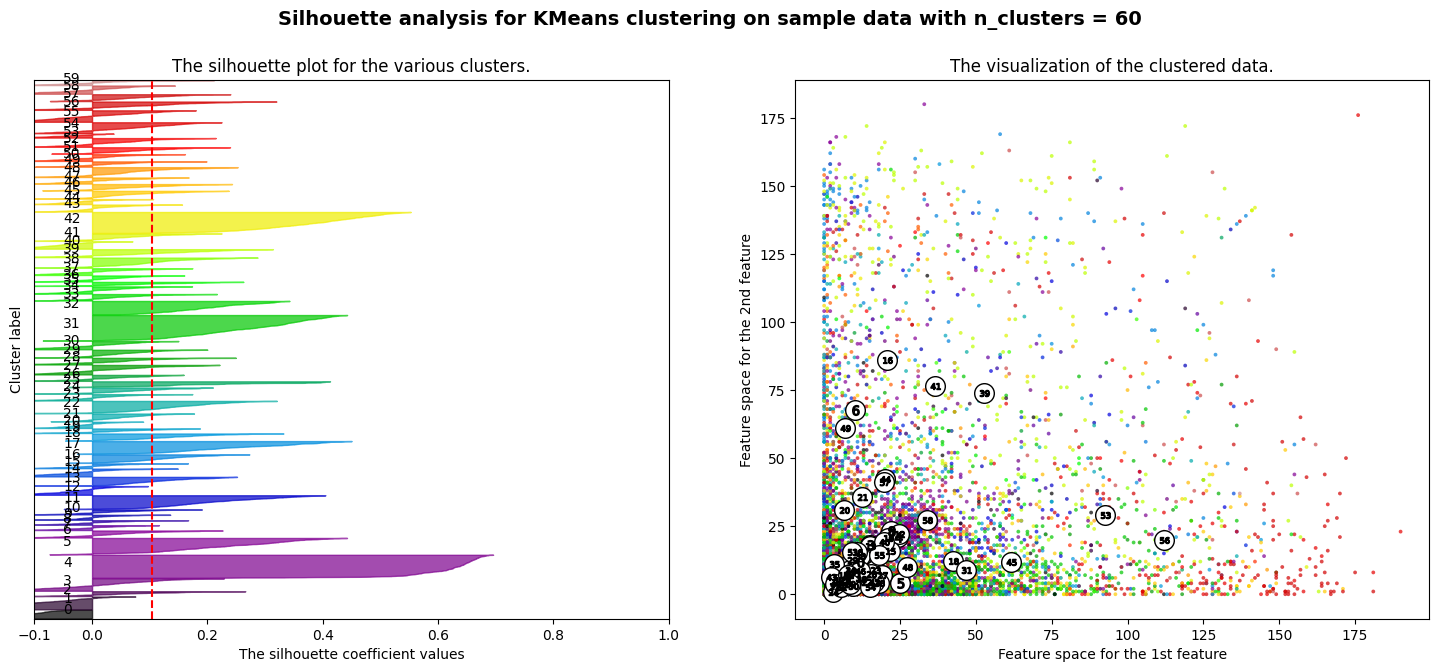

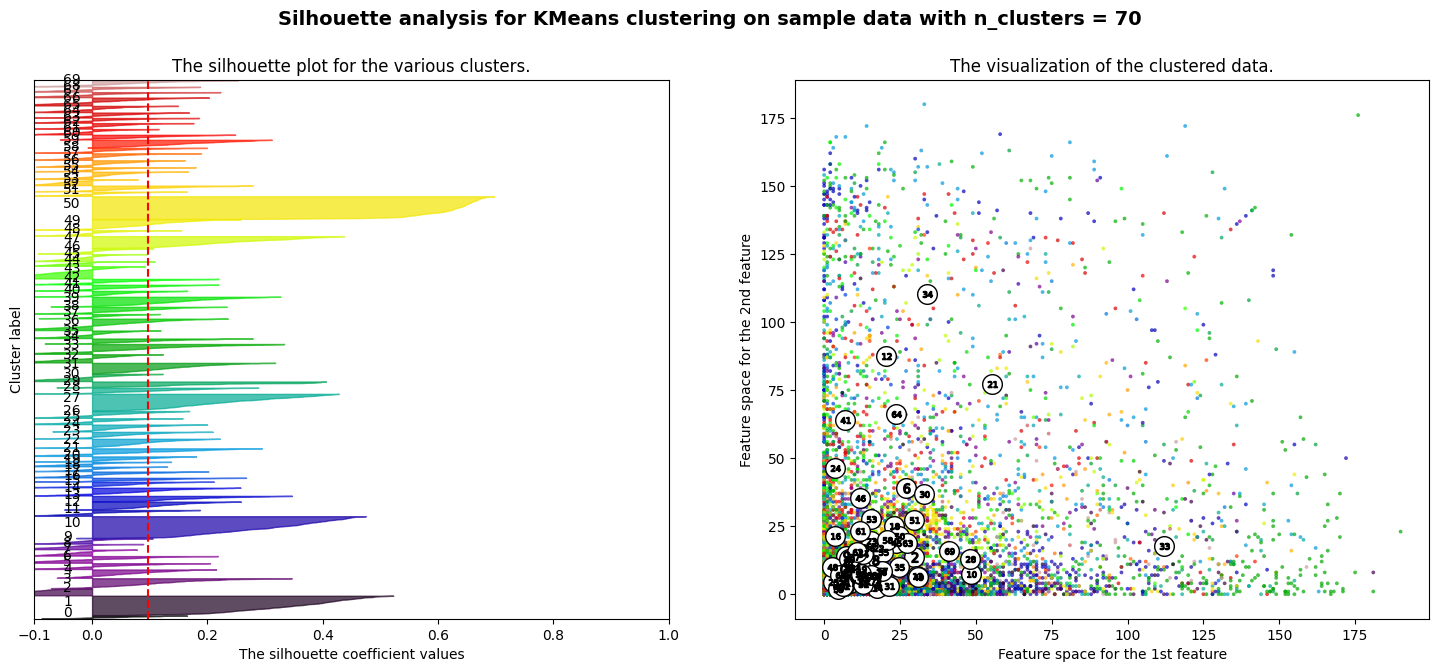

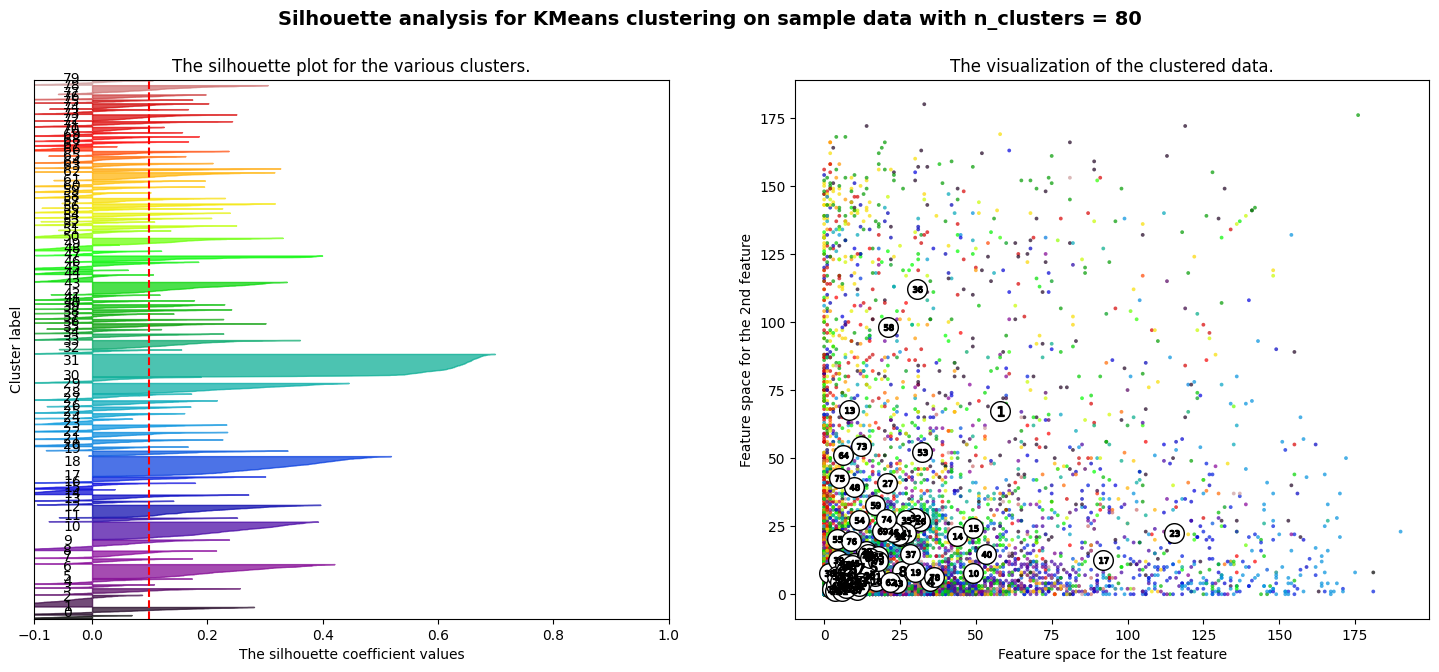

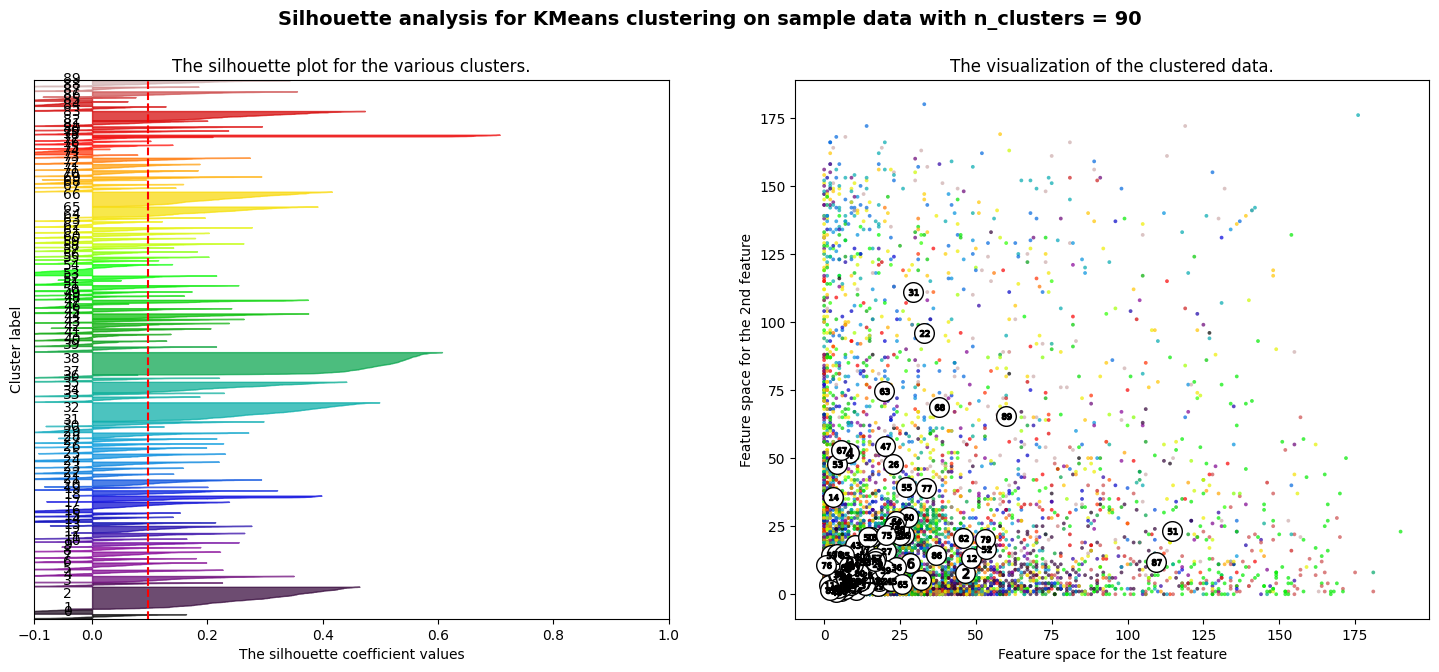

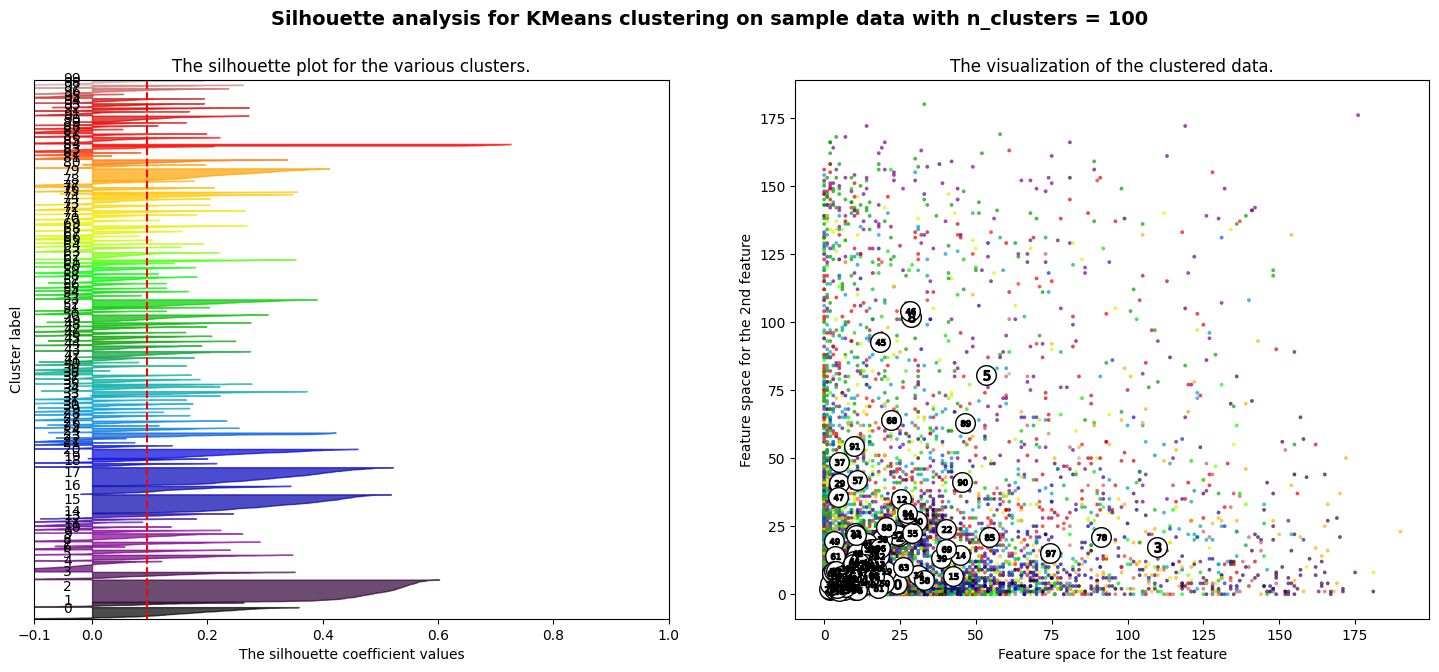

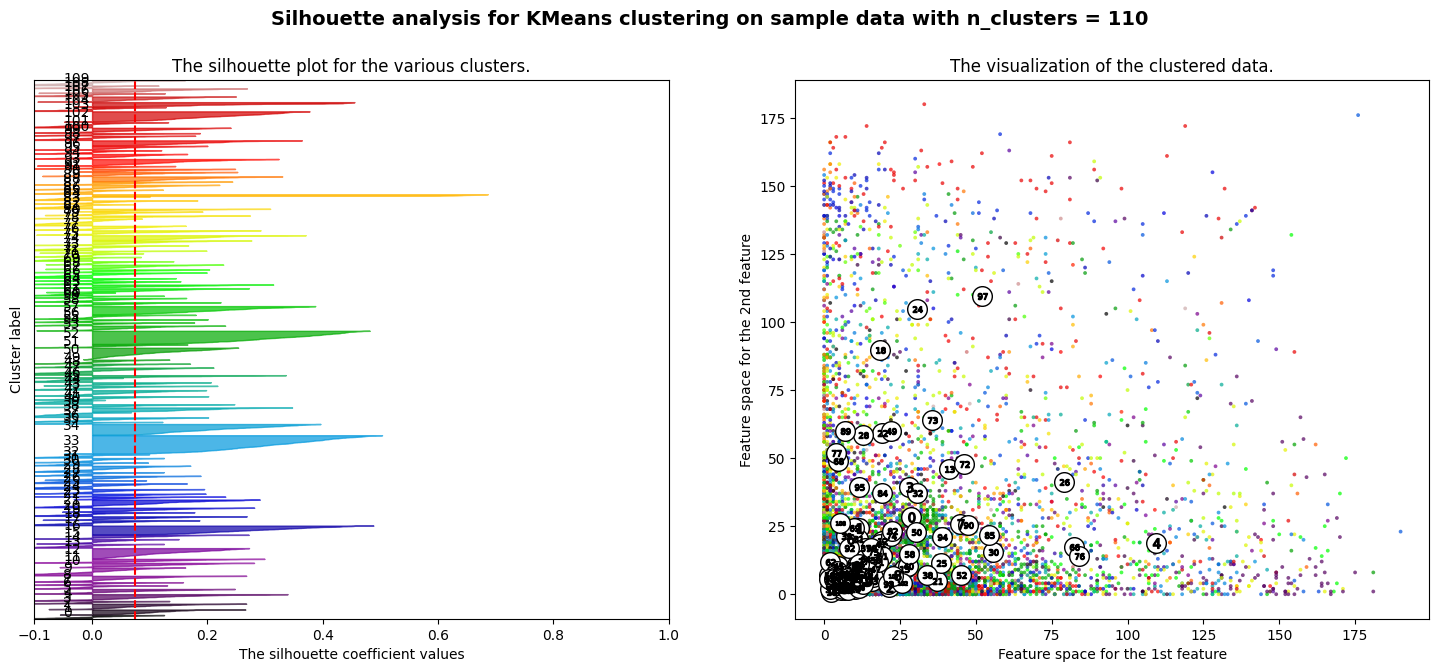

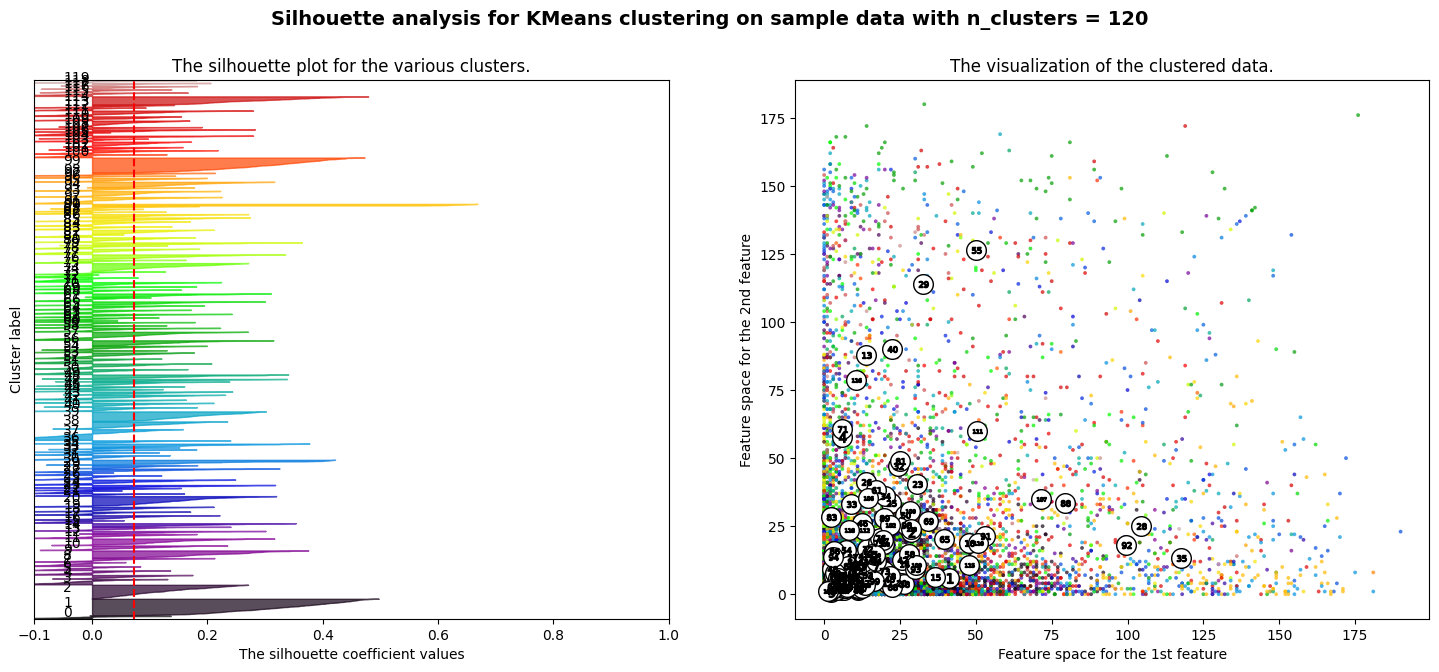

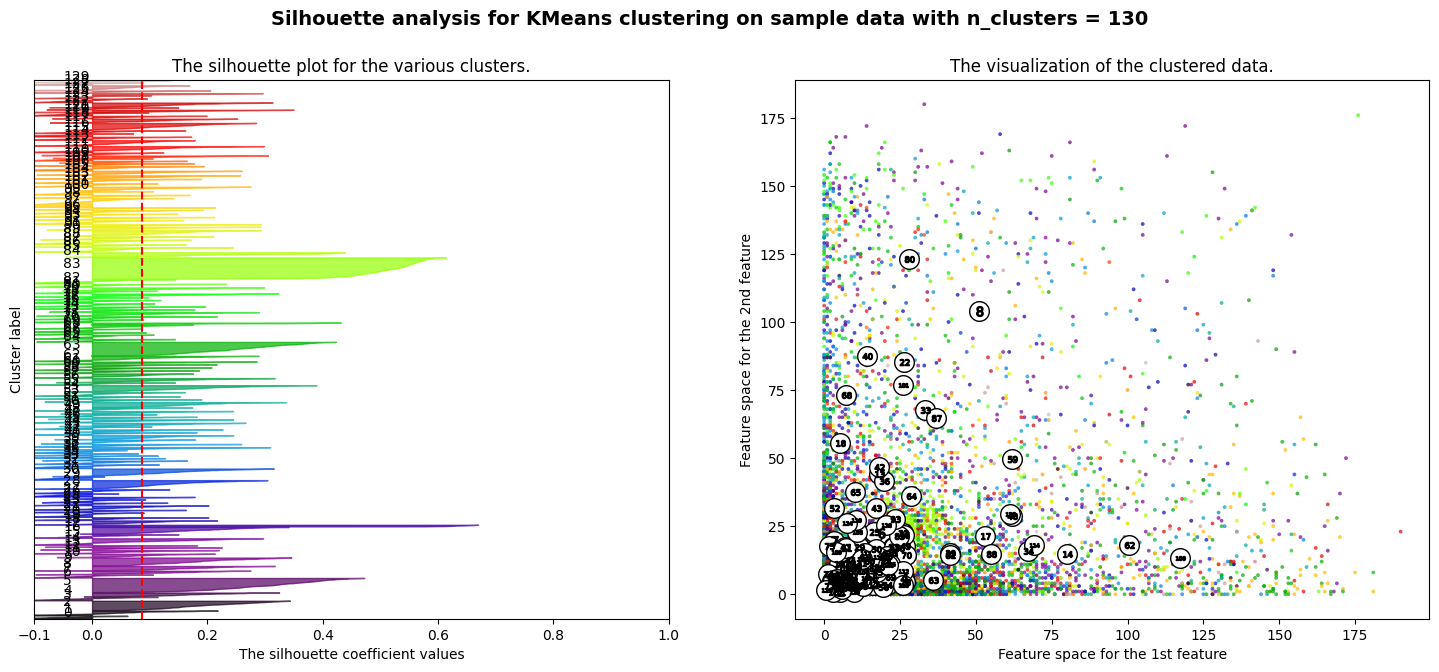

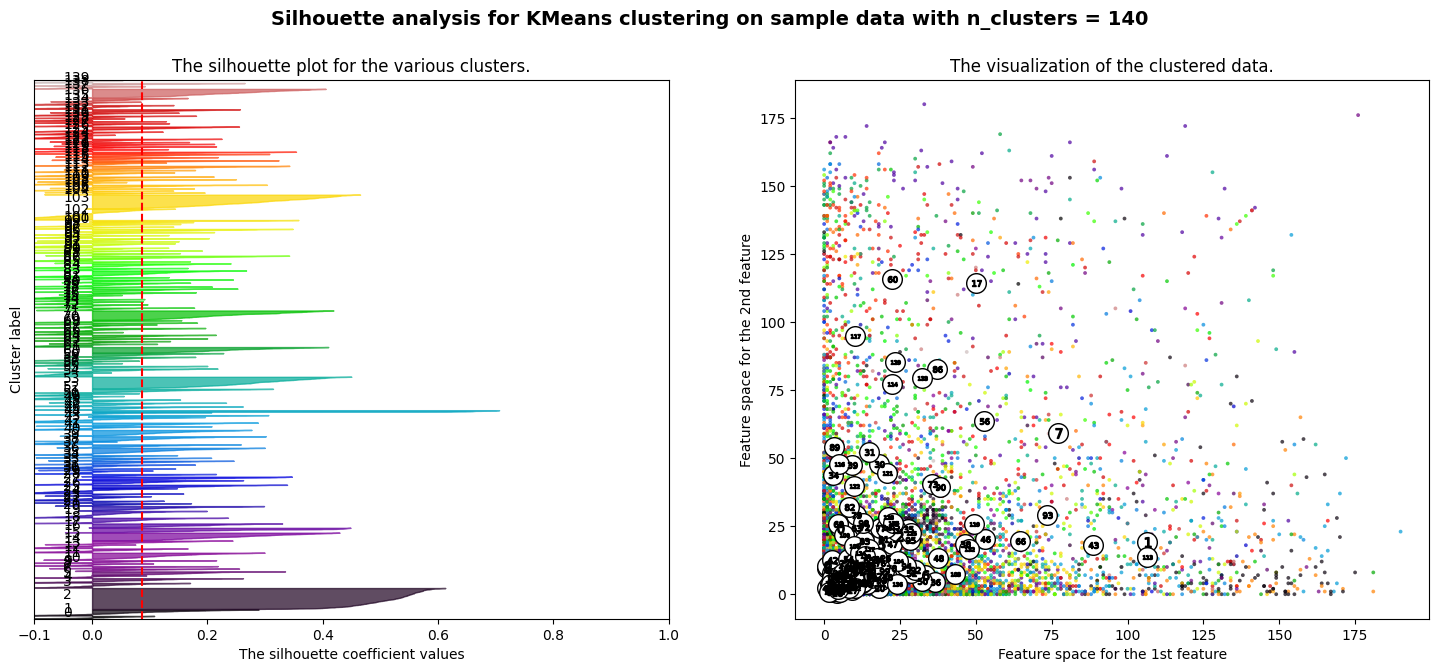

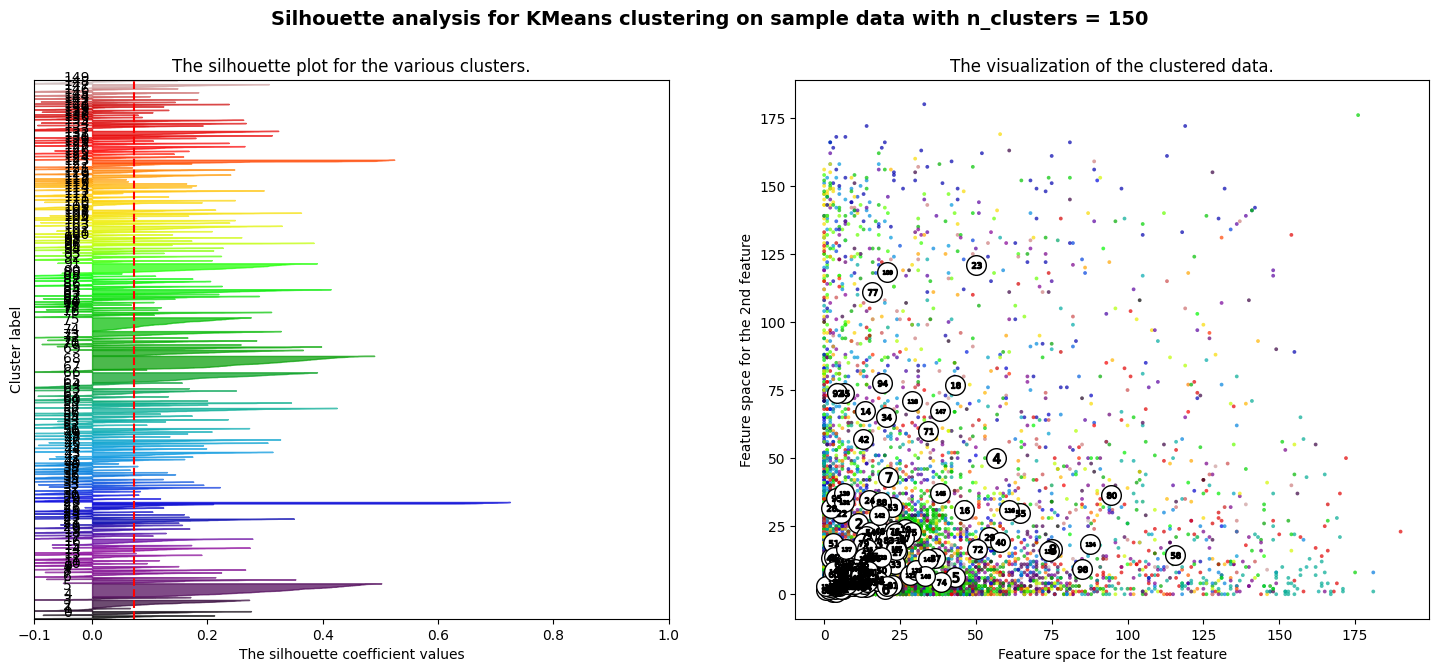

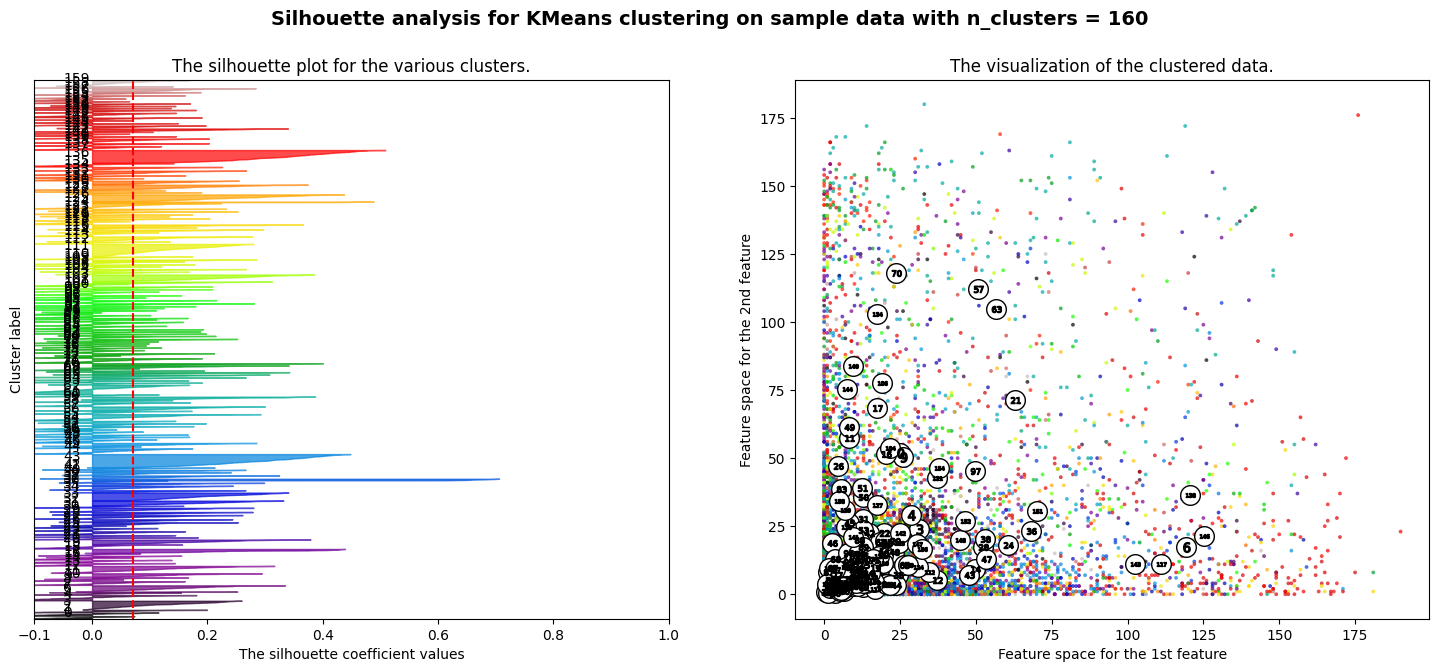

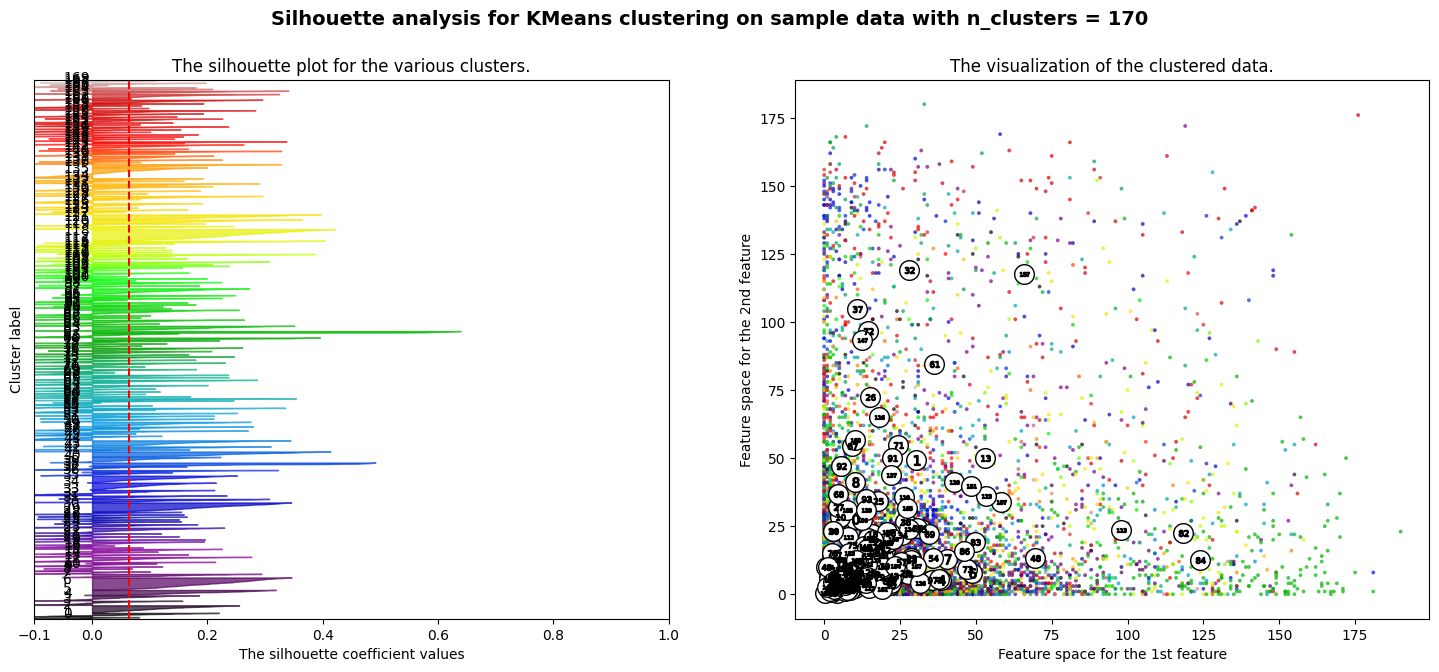

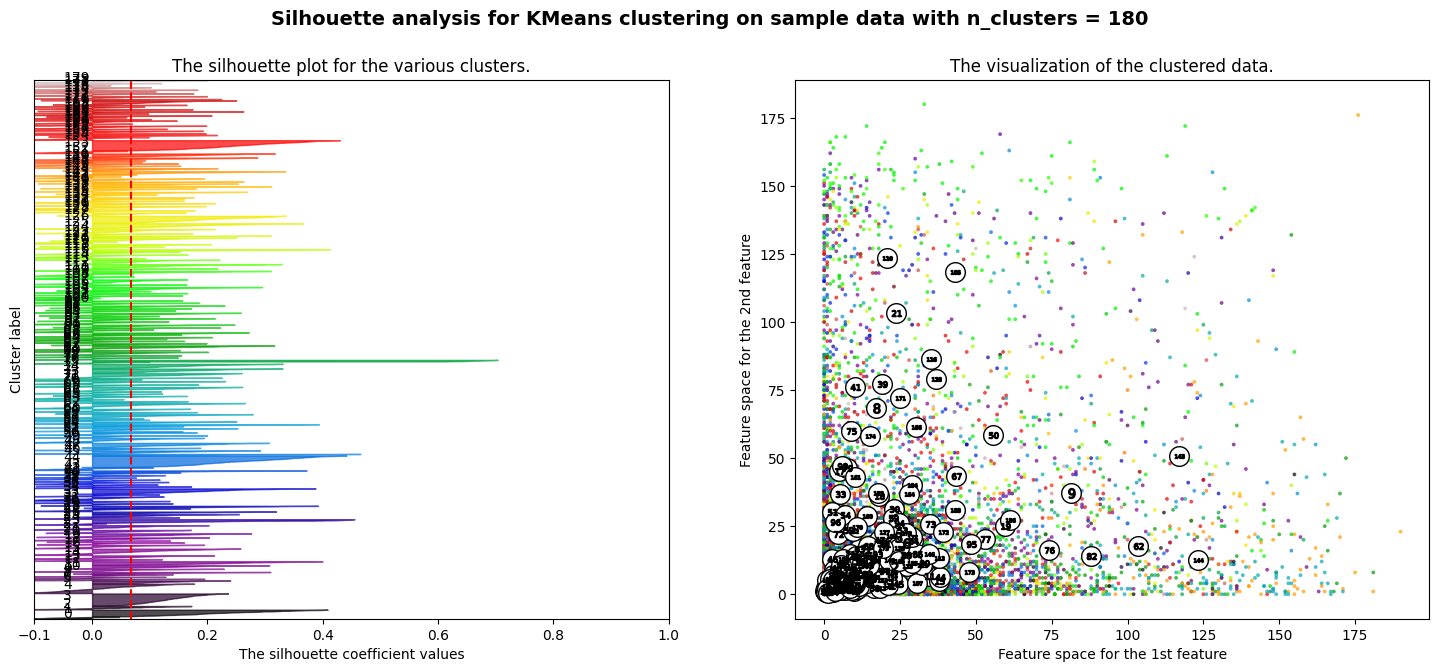

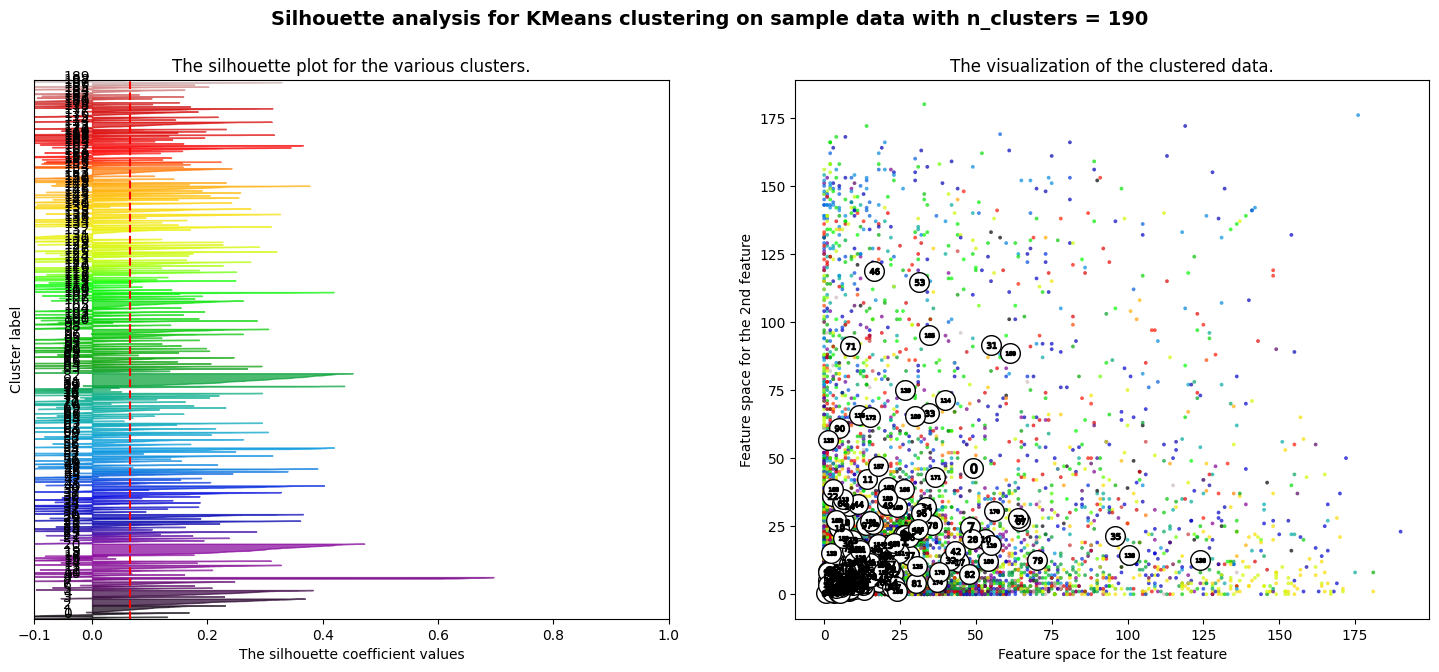

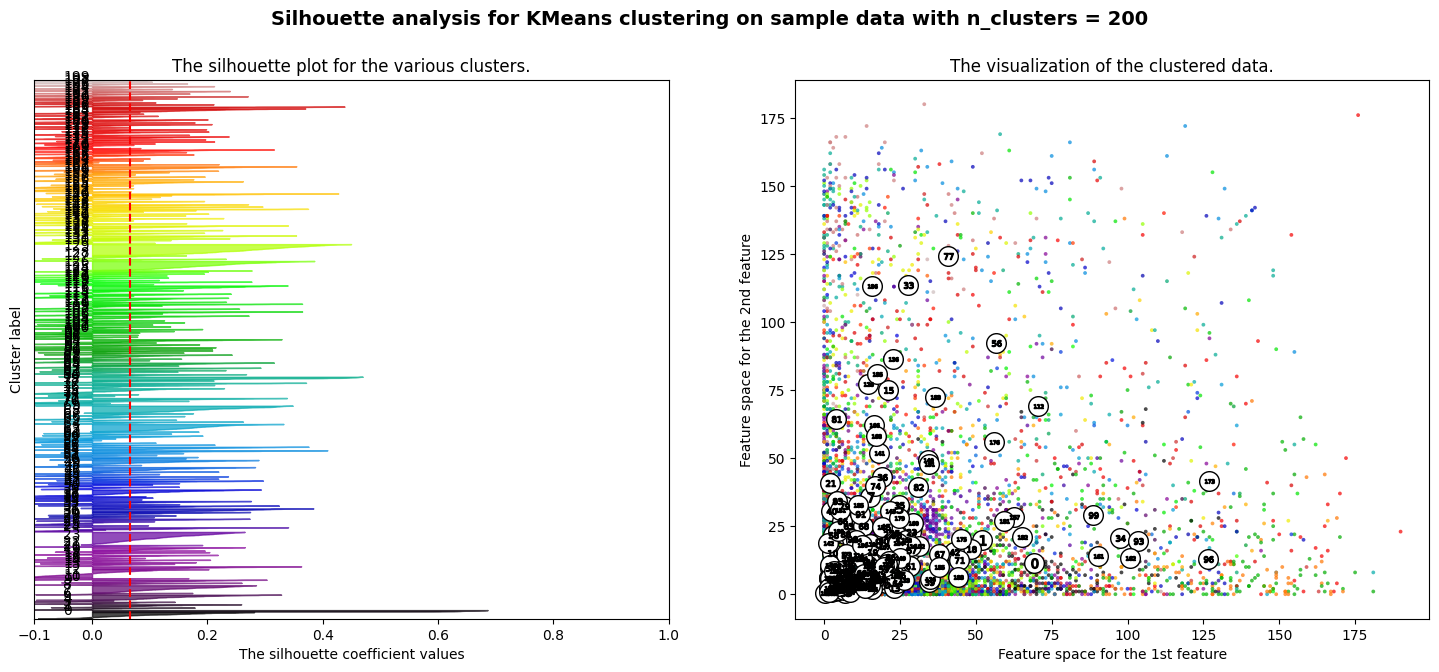

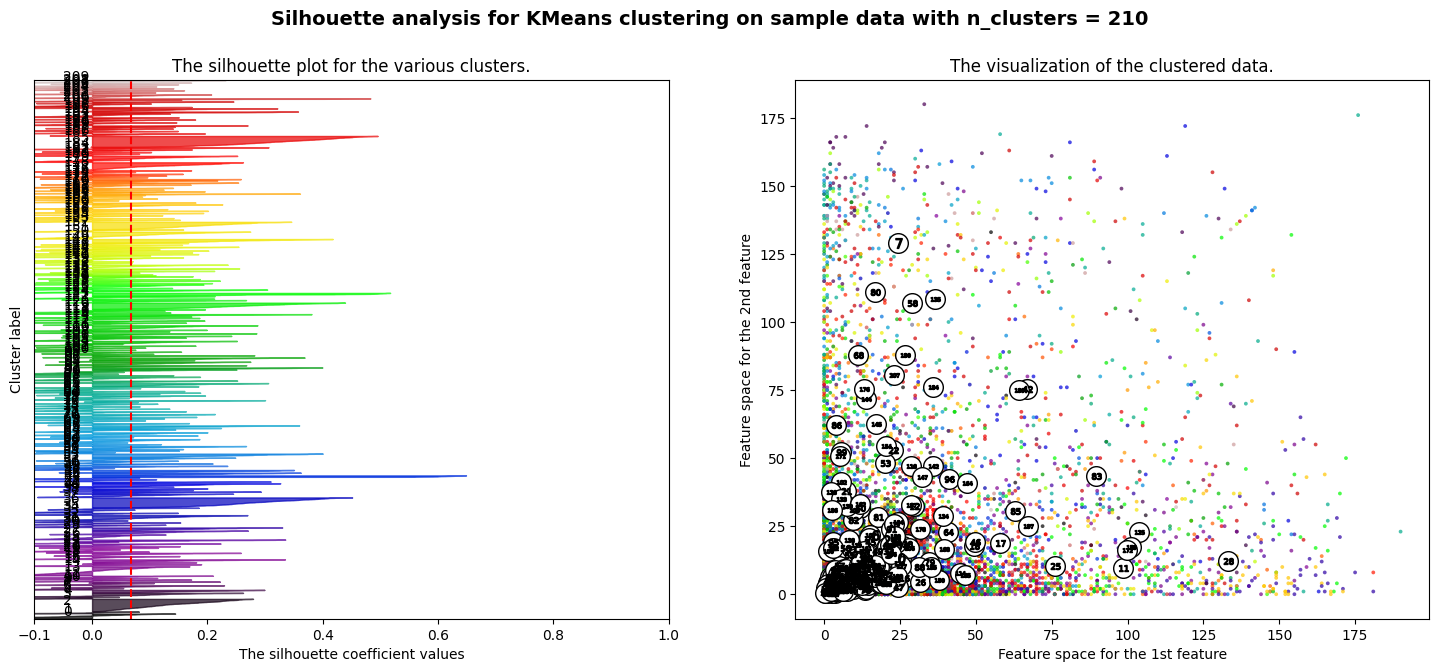

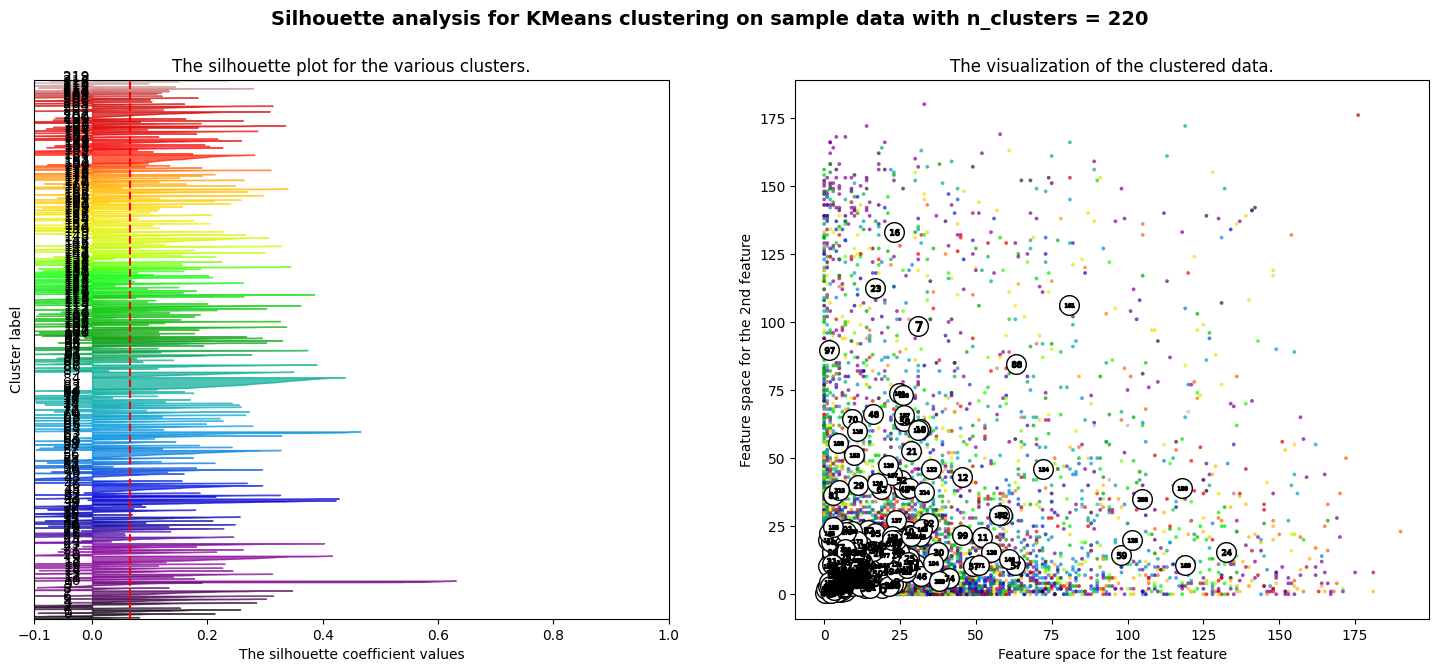

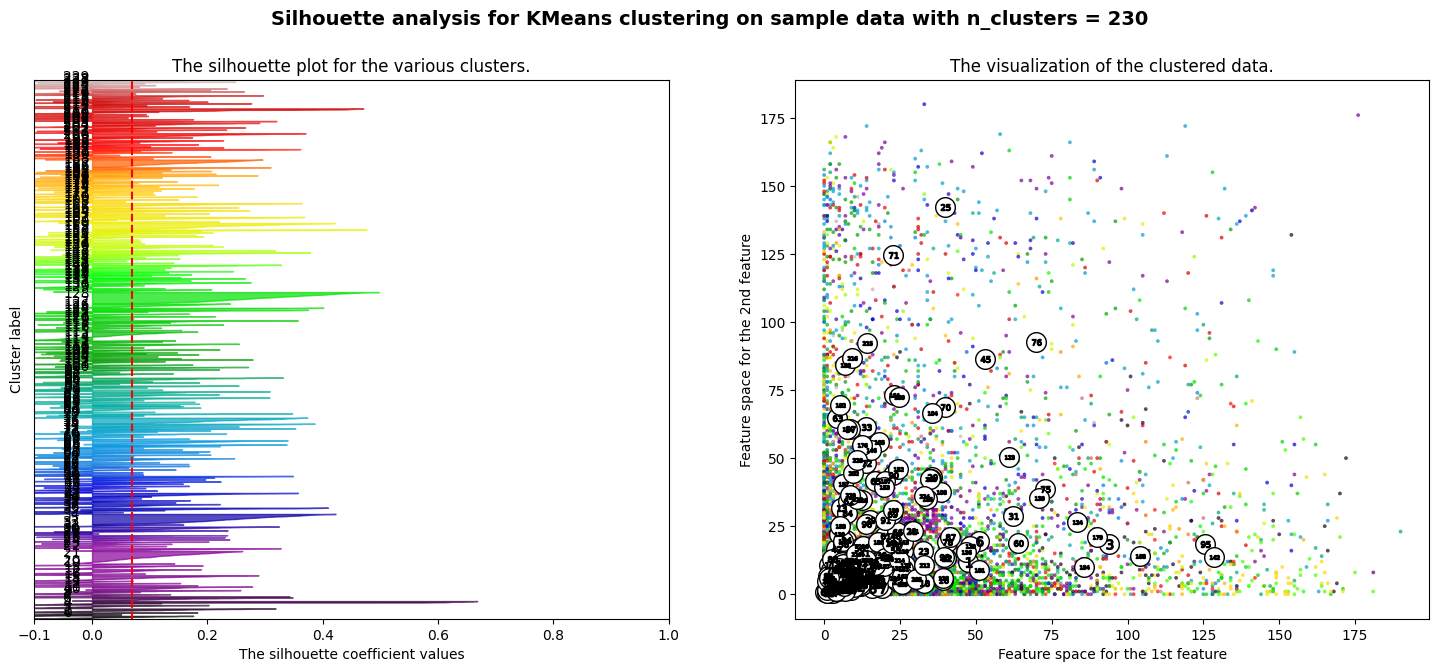

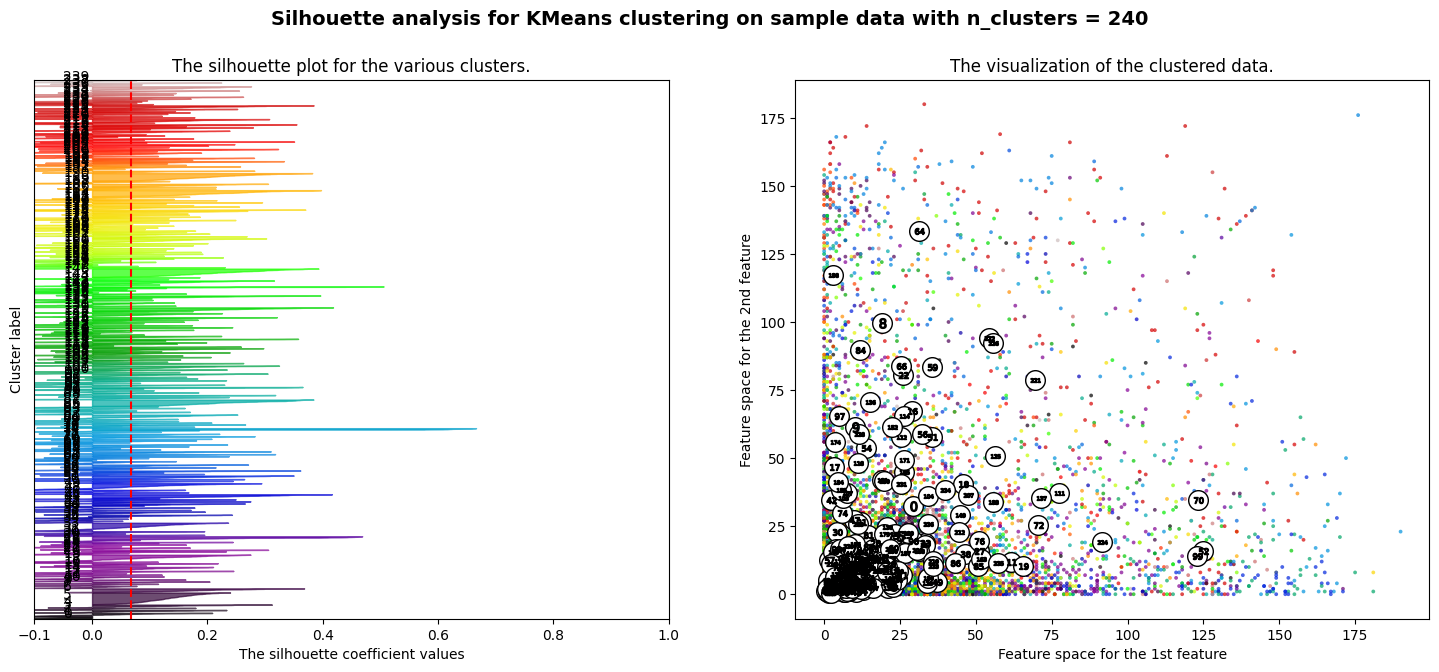

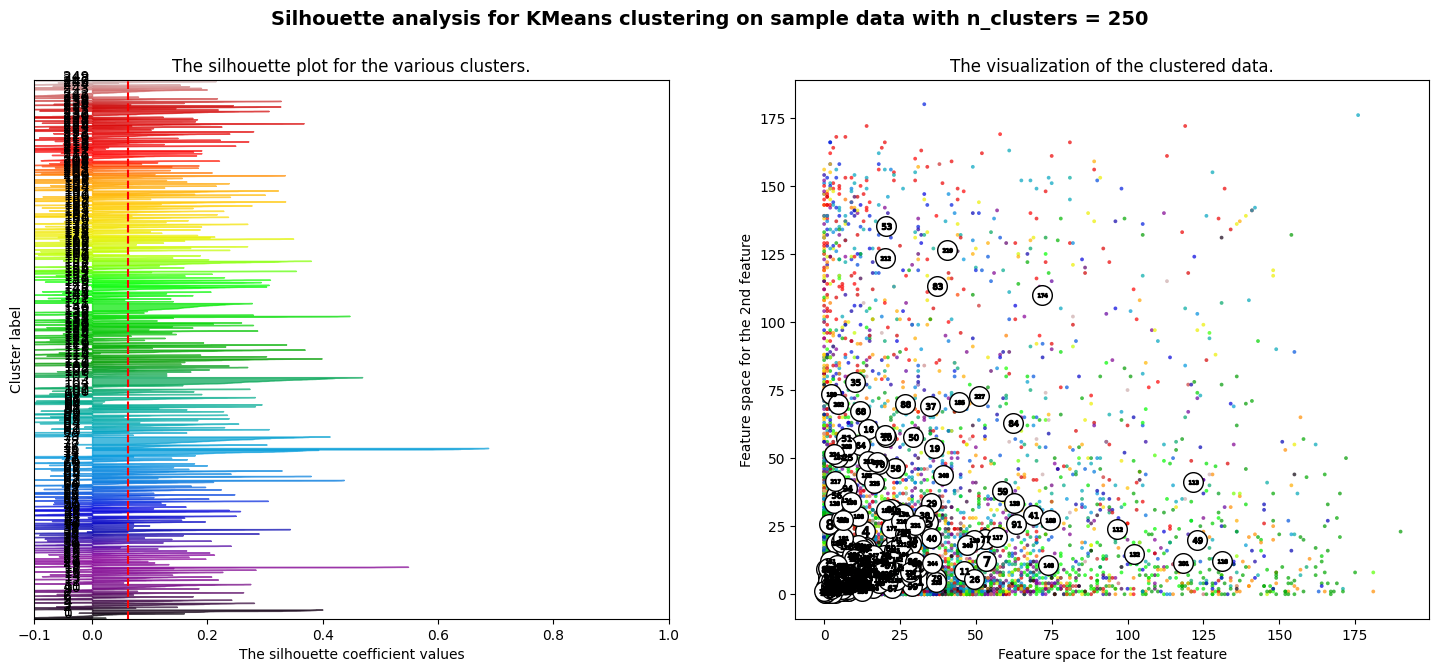

In [150]:
dictionary.silhouette(k_3)

### Creating Dictionary using Best K = 100 to get the Train and Test data

In [42]:
dictionary_100 = Dictionary("d100", training_file_names)
training_word_histograms_100 = dictionary_100.learn(100)
word_histograms_100 = dictionary_100.create_word_histograms(test_file_names, 100)

### Hyperparameter Tuning of Classifiers 

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
validation_data = get_data('Val')
validation_file_names = validation_data[0]
validation_tool_labels = validation_data[1]

In [64]:
dictionary_name_val = 'tune'
dictionary_val = Dictionary(dictionary_name, validation_file_names)

In [65]:
validation_word_histograms_100 = dictionary_val.learn(100)

#### k-NN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
def tune_knn():
    k_space =  [4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]
    param_grid = {'n_neighbors': k_space}

    # Instantiating KNN classifier
    knn = KNeighborsClassifier()

    # Instantiating the GridSearchCV object with the Validation Dataset
    knn_cv = GridSearchCV(knn, param_grid, scoring = 'accuracy', cv = 5)
    knn_cv.fit(validation_word_histograms_100, validation_tool_labels)

    # Print the tuned parameters and score
    print("Tuned K- Nearest Neighbours Parameters: {}".format(knn_cv.best_params_))
    print("Best score is {}".format(knn_cv.best_score_))

In [67]:
tune_knn()

Tuned K- Nearest Neighbours Parameters: {'n_neighbors': 9}
Best score is 0.4833333333333334


#### SVM

In [23]:
from sklearn import svm

In [68]:
def tune_svm():
    c_space = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50]
    param_grid = {'C': c_space}

    # Instantiating SVM classifier
    svc = svm.SVC(kernel = 'linear')

    # Instantiating the GridSearchCV object with the Validation Dataset
    svc_cv = GridSearchCV(svc, param_grid, scoring = 'accuracy', cv = 5)
    svc_cv.fit(validation_word_histograms_100, validation_tool_labels)

    # Print the tuned parameters and score
    print("Tuned Linear Kernel SVM Parameters: {}".format(svc_cv.best_params_))
    print("Best score is {}".format(svc_cv.best_score_))

In [69]:
tune_svm()

Tuned Linear Kernel SVM Parameters: {'C': 30}
Best score is 0.6000000000000001


#### AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostClassifier

In [114]:
def tune_adaboost():
    n_space =  [150, 160, 165, 170, 175, 180, 200, 250]
    param_grid = {'n_estimators': n_space}

    # Instantiating SVM classifier
    adb = AdaBoostClassifier(random_state = 0)

    # Instantiating the GridSearchCV object with the Validation Dataset
    adb_cv = GridSearchCV(adb, param_grid, scoring = 'accuracy', cv = 5)
    adb_cv.fit(validation_word_histograms_100, validation_tool_labels)

    # Print the tuned parameters and score
    print("Tuned AdaBoost Parameters: {}".format(adb_cv.best_params_))
    print("Best score is {}".format(adb_cv.best_score_))

In [115]:
tune_adaboost()

Tuned AdaBoost Parameters: {'n_estimators': 250}
Best score is 0.4833333333333333


### Metrics

In [29]:
def get_confusion_matrix(predicted_tool_labels):
    return confusion_matrix(test_tool_labels, predicted_tool_labels)

In [30]:
def get_classification_report(predicted_tool_labels):
    return classification_report(test_tool_labels, predicted_tool_labels, target_names=tools)

### SVM Classifier

In [58]:
def get_svm_classifier_(C_value):
    svm_classifier = svm.SVC(C=C_value, kernel = 'linear', random_state=42)
    svm_classifier.fit(training_word_histograms_100, training_tool_labels)
    return svm_classifier

In [74]:
svm_classifier_ = get_svm_classifier_(50) # tried with 30, gave 0.63 accuracy

In [75]:
svm_predicted_tool_labels_ = svm_classifier_.predict(word_histograms_100)

In [76]:
print(get_confusion_matrix(svm_predicted_tool_labels_))

[[16  1  8  7]
 [ 2 24  5  1]
 [ 4  6 21  1]
 [ 3  4  0 25]]


In [77]:
print(get_classification_report(svm_predicted_tool_labels_))

              precision    recall  f1-score   support

      hammer       0.64      0.50      0.56        32
      pliers       0.69      0.75      0.72        32
screw_driver       0.62      0.66      0.64        32
      wrench       0.74      0.78      0.76        32

    accuracy                           0.67       128
   macro avg       0.67      0.67      0.67       128
weighted avg       0.67      0.67      0.67       128



### k-NN Classifier

In [81]:
def get_knn_classifier_(neighbours):
    knn = KNeighborsClassifier(n_neighbors = neighbours)
    knn.fit(training_word_histograms_100, training_tool_labels)
    return knn

In [110]:
knn_ = get_knn_classifier_(9)

In [111]:
knn_predicted_tool_labels_ = knn_.predict(word_histograms_100)

In [112]:
print(get_confusion_matrix(knn_predicted_tool_labels_))

[[13 13  1  5]
 [ 5 27  0  0]
 [ 7 20  3  2]
 [ 8 10  1 13]]


In [113]:
print(get_classification_report(knn_predicted_tool_labels_))

              precision    recall  f1-score   support

      hammer       0.39      0.41      0.40        32
      pliers       0.39      0.84      0.53        32
screw_driver       0.60      0.09      0.16        32
      wrench       0.65      0.41      0.50        32

    accuracy                           0.44       128
   macro avg       0.51      0.44      0.40       128
weighted avg       0.51      0.44      0.40       128



### AdaBoost Classifier

In [116]:
def get_adb_classifier_(num_estimators):
    adb_classifier = AdaBoostClassifier(n_estimators = num_estimators, random_state = 42)
    adb_classifier.fit(training_word_histograms_100, training_tool_labels)
    return adb_classifier

In [146]:
adb_classifier_ = get_adb_classifier_(80) # 250 gave very poor accuracy

In [147]:
adb_predicted_tool_labels_ = adb_classifier_.predict(word_histograms_100)

In [148]:
print(get_confusion_matrix(adb_predicted_tool_labels_))

[[25  2  3  2]
 [ 7 18  4  3]
 [13  4 15  0]
 [ 8  1  2 21]]


In [149]:
print(get_classification_report(adb_predicted_tool_labels_))

              precision    recall  f1-score   support

      hammer       0.47      0.78      0.59        32
      pliers       0.72      0.56      0.63        32
screw_driver       0.62      0.47      0.54        32
      wrench       0.81      0.66      0.72        32

    accuracy                           0.62       128
   macro avg       0.66      0.62      0.62       128
weighted avg       0.66      0.62      0.62       128

